In [24]:
from sklearn.datasets import load_breast_cancer
import pandas as pd
import matplotlib.pyplot as plt

data = load_breast_cancer()
df_pandas = pd.DataFrame(data.data, columns=data.feature_names)
df_pandas.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [25]:
from pyspark.sql import SparkSession

# Crear sesión de Spark
spark = SparkSession.builder.appName("PCA_Breast_Cancer").getOrCreate()

# Convertir a DataFrame de PySpark
df_spark = spark.createDataFrame(df_pandas)

# Mostrar el esquema
df_spark.printSchema()

root
 |-- mean radius: double (nullable = true)
 |-- mean texture: double (nullable = true)
 |-- mean perimeter: double (nullable = true)
 |-- mean area: double (nullable = true)
 |-- mean smoothness: double (nullable = true)
 |-- mean compactness: double (nullable = true)
 |-- mean concavity: double (nullable = true)
 |-- mean concave points: double (nullable = true)
 |-- mean symmetry: double (nullable = true)
 |-- mean fractal dimension: double (nullable = true)
 |-- radius error: double (nullable = true)
 |-- texture error: double (nullable = true)
 |-- perimeter error: double (nullable = true)
 |-- area error: double (nullable = true)
 |-- smoothness error: double (nullable = true)
 |-- compactness error: double (nullable = true)
 |-- concavity error: double (nullable = true)
 |-- concave points error: double (nullable = true)
 |-- symmetry error: double (nullable = true)
 |-- fractal dimension error: double (nullable = true)
 |-- worst radius: double (nullable = true)
 |-- worst 

In [26]:
from pyspark.ml.feature import VectorAssembler

# Unir todas las columnas en un solo vector de características
feature_columns = df_spark.columns  # Todas las columnas del dataset
vector_assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Transformar el DataFrame
df_vector = vector_assembler.transform(df_spark)

# Seleccionar solo la columna "features" para PCA
df_vector.select("features").show(truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|features                                                                                                                                                                                                                 |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[17.99,10.38,122.8,1001.0,0.1184,0.2776,0.3001,0.1471,0.2419,0.07871,1.095,0.9053,8.589,153.4,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.1189]      |
|[20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01

In [27]:
from pyspark.ml.feature import PCA

# Aplicar PCA para reducir a 3 componentes principales
pca = PCA(k=3, inputCol="features", outputCol="pca_features")
pca_model = pca.fit(df_vector)

# Transformar los datos
df_pca = pca_model.transform(df_vector)

# Mostrar las primeras filas con los nuevos componentes
df_pca.show()

+-----------+------------+--------------+---------+---------------+----------------+--------------+-------------------+-------------+----------------------+------------+-------------+---------------+----------+----------------+-----------------+---------------+--------------------+--------------+-----------------------+------------+-------------+---------------+----------+----------------+-----------------+---------------+--------------------+--------------+-----------------------+--------------------+--------------------+
|mean radius|mean texture|mean perimeter|mean area|mean smoothness|mean compactness|mean concavity|mean concave points|mean symmetry|mean fractal dimension|radius error|texture error|perimeter error|area error|smoothness error|compactness error|concavity error|concave points error|symmetry error|fractal dimension error|worst radius|worst texture|worst perimeter|worst area|worst smoothness|worst compactness|worst concavity|worst concave points|worst symmetry|worst fra

In [28]:
explained_variance = pca_model.explainedVariance
print("Varianza explicada por cada componente principal:", explained_variance)

Varianza explicada por cada componente principal: [0.9820446715106617,0.01617648986351111,0.001557510745015239]


In [29]:
df_pandas_pca = df_pca.select("pca_features").toPandas()
df_pandas_pca.head()

,pca_features
0,"[-2260.01388629254, -187.96030122263645, 17.91..."
1,"[-2368.993755782053, 121.58742425815554, -66.0..."
2,"[-2095.66520154786, 145.11398565870155, -32.37..."
3,"[-692.6905100570506, 38.57692259208188, -21.99..."
4,"[-2030.2124927427053, 295.29798399279287, -29...."


In [30]:
import pandas as pd

# Supongamos que ya tenemos el DataFrame con la columna "pca_features"
df_pandas_pca_expanded = df_pandas_pca["pca_features"].apply(pd.Series)

# Renombrar las columnas para mayor claridad
df_pandas_pca_expanded.columns = [f"PCA_{i+1}" for i in range(df_pandas_pca_expanded.shape[1])]

# Mostrar las primeras filas
df_pandas_pca_expanded.head()

,PCA_1,PCA_2,PCA_3
0,-2260.013886,-187.960301,17.912961
1,-2368.993756,121.587424,-66.059971
2,-2095.665202,145.113986,-32.375189
3,-692.690510,38.576923,-21.992589
4,-2030.212493,295.297984,-29.290636


In [31]:
df_pandas_pca_expanded['target'] = data.target
df_pandas_pca_expanded.head()

,PCA_1,PCA_2,PCA_3,target
0,-2260.013886,-187.960301,17.912961,0
1,-2368.993756,121.587424,-66.059971,0
2,-2095.665202,145.113986,-32.375189,0
3,-692.690510,38.576923,-21.992589,0
4,-2030.212493,295.297984,-29.290636,0


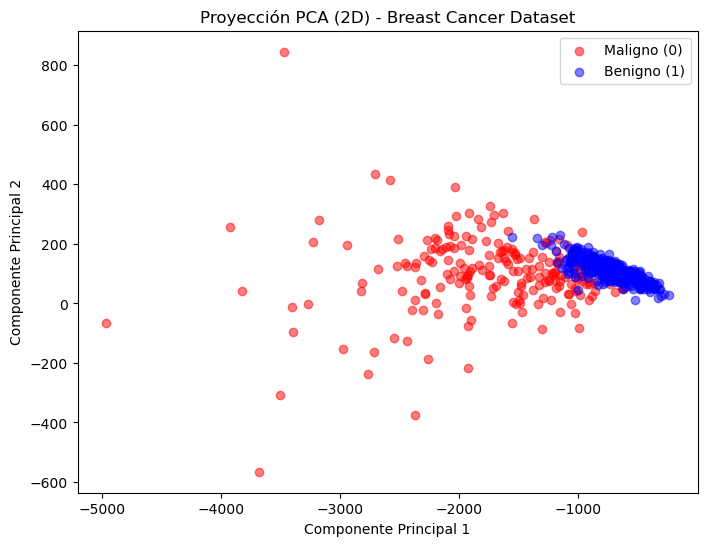

In [32]:
plt.figure(figsize=(8,6))
maligno = df_pandas_pca_expanded[df_pandas_pca_expanded["target"] == 0]
benigno = df_pandas_pca_expanded[df_pandas_pca_expanded["target"] == 1]

plt.scatter(maligno["PCA_1"], maligno["PCA_2"], c="red", label="Maligno (0)", alpha=0.5)
plt.scatter(benigno["PCA_1"], benigno["PCA_2"], c="blue", label="Benigno (1)", alpha=0.5)
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.title("Proyección PCA (2D) - Breast Cancer Dataset")
plt.legend()
plt.show()

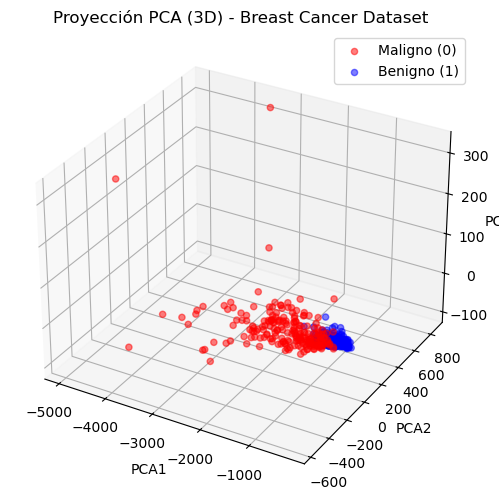

In [33]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(maligno["PCA_1"], maligno["PCA_2"], maligno["PCA_3"], 
           c="red", label="Maligno (0)", alpha=0.5)

ax.scatter(benigno["PCA_1"], benigno["PCA_2"], benigno["PCA_3"], 
           c="blue", label="Benigno (1)", alpha=0.5)

ax.set_xlabel("PCA1")
ax.set_ylabel("PCA2")
ax.set_zlabel("PCA3")
ax.set_title("Proyección PCA (3D) - Breast Cancer Dataset")
ax.legend()
plt.show()